# KNN Model for predicting Racket Type with Attack Time - Vibration

### Import libraries

In [ ]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.signal import find_peaks
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score


### Import Tools Functions

Readcsv function

In [ ]:
from Functions.readWavFolder import readWavFolder

# P1 = readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P1_clean")

ModuleNotFoundError: No module named 'Functions'

Spectrum

In [6]:
from Functions.spectrumFromSignal import spectrumFromSignal

# testData = P1[0][1].to_numpy()
# testDataSpectrum, freqTest = spectrumFromSignal(testData, 20000)

Plot Spectrum

In [7]:
from Functions.plot_spectrum_with_freq import plot_spectrum_with_freq

# Example usage
# plot_spectrum_with_freq(testDataSpectrum, freqTest, title="Spectrum of Test Data")


Extract each peak and store

In [8]:
from Functions.extractNPeak import extractNPeak



Attack Time

In [9]:
def calculate_attack_time(signal, sample_rate, threshold=0.9):
    # Ensure the signal is a 1-D array
    signal = signal.flatten()

    # Find the peak amplitude
    peak_amplitude = np.max(signal)

    # Find the index where the signal first reaches the threshold of the peak amplitude
    attack_index = np.argmax(signal >= threshold * peak_amplitude)

    # Calculate the attack time in seconds
    attack_time = attack_index / sample_rate

    return attack_time

# Example usage
# attack_time = calculate_attack_time(testDataSpectrum, sample_rate=20000)
# print(f"Attack Time: {attack_time} seconds")

# Main

In [10]:
raquetteTypeList = {"RB":0,"RO":1,"RR":2,"RV":3}
raquetteAgeList = {"P1":1,"P2":2,"P3":3}



sampleRateFolderP1=[]
sampleRateFolderP2=[]
sampleRateFolderP3=[]

P1=readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P1_clean")
P2=readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P2_clean")
P3=readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P3_clean")

print(len(P1),len(P2),len(P3))


# Combine all data into a single DataFrame with equal repartition of ages
all_data = []

# Find the minimum number of samples across all ages
min_samples_per_age = min(len(P1), len(P2), len(P3))

# Limit the data for each age to the minimum number of samples
for dataset, age in zip([P1[:min_samples_per_age], P2[:min_samples_per_age], P3[:min_samples_per_age]], ["P1", "P2", "P3"]):
    for label, df in dataset:
        spectrum_points = df.iloc[:, 0].tolist()  # Convert the first column to a list of spectrum points
        all_data.append({
            "Spectrum": spectrum_points,
            "Label": label,
            "Age": age
        })

# Convert the list of dictionaries into a DataFrame
df_combined = pd.DataFrame(all_data)
print(df_combined)




216 324 255
                                              Spectrum Label Age
0    [-0.0157396069269226, -0.0247020394436264, -0....    RB  P1
1    [0.1018583712467967, 0.1009078102222978, 0.088...    RB  P1
2    [-0.027010544788838, -0.0150606347665663, -0.0...    RB  P1
3    [-0.0568732668509613, -0.0635271940224535, -0....    RB  P1
4    [-0.0867480419066406, -0.0499477508153265, -0....    RB  P1
..                                                 ...   ...  ..
643  [-0.0032282485048386, -0.0111029046295602, -0....    RV  P3
644  [-0.0174840914892484, -0.0420584493957072, -0....    RV  P3
645  [-0.0583508413778898, -0.0398861304647495, -0....    RV  P3
646  [-0.0147686928255513, -0.0130036836941482, 0.0...    RV  P3
647  [-0.008523275899048, -0.0104240549636359, 0.01...    RV  P3

[648 rows x 3 columns]


In [11]:
# Define the band width
band_width = 20

# Compute attack time for each row in the DataFrame
df_combined['AttackTime'] = df_combined['Spectrum'].apply(
    lambda signal: calculate_attack_time(signal=np.array(signal), sample_rate=20000)
)

print(df_combined)

                                              Spectrum Label Age  AttackTime
0    [-0.0157396069269226, -0.0247020394436264, -0....    RB  P1     0.01945
1    [0.1018583712467967, 0.1009078102222978, 0.088...    RB  P1     0.01940
2    [-0.027010544788838, -0.0150606347665663, -0.0...    RB  P1     0.01940
3    [-0.0568732668509613, -0.0635271940224535, -0....    RB  P1     0.01950
4    [-0.0867480419066406, -0.0499477508153265, -0....    RB  P1     0.01950
..                                                 ...   ...  ..         ...
643  [-0.0032282485048386, -0.0111029046295602, -0....    RV  P3     0.01960
644  [-0.0174840914892484, -0.0420584493957072, -0....    RV  P3     0.01960
645  [-0.0583508413778898, -0.0398861304647495, -0....    RV  P3     0.01945
646  [-0.0147686928255513, -0.0130036836941482, 0.0...    RV  P3     0.01950
647  [-0.008523275899048, -0.0104240549636359, 0.01...    RV  P3     0.01960

[648 rows x 4 columns]


In [12]:
# Combine features into X
X = df_combined[["AttackTime"]].to_numpy()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_combined["Age"])

# # print(y)
# print(len(X),len(y))

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(X,y)


In [13]:
# Définir les bonnes valeurs trouvé
n_neighbors = 10  # Nombre de voisins
weights_options = ['uniform']  # Méthode de pondération
metric_options = ['manhattan']  # Métriques


# Définir les plages de valeurs pour les hyperparamètres
n_neighbors_range = range(1, 21)  # Nombre de voisins
weights_options = ['uniform', 'distance']  # Méthode de pondération
metric_options = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']  # Métriques

# Liste pour stocker les résultats
results = []


# Tester toutes les combinaisons d'hyperparamètres
for n_neighbors in n_neighbors_range:
    for weights in weights_options:
        for metric in metric_options:
            # Créer et entraîner le modèle KNN
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
            knn.fit(X_train, y_train)

            # Évaluer sur l'ensemble de test
            y_pred = knn.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)

            # Évaluer sur l'ensemble d'entraînement
            y_train_pred = knn.predict(X_train)
            accuracy_train = accuracy_score(y_train, y_train_pred)

            # Ajouter les résultats à la liste
            results.append({
                'n_neighbors': n_neighbors,
                'weights': weights,
                'metric': metric,
                'accuracy_train': accuracy_train,
                'accuracy_test': accuracy_test
            })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)



print(results_df)

     n_neighbors   weights     metric  accuracy_train  accuracy_test
0              1   uniform  euclidean        0.449807       0.484615
1              1   uniform  manhattan        0.449807       0.484615
2              1   uniform  chebyshev        0.449807       0.484615
3              1   uniform  minkowski        0.449807       0.484615
4              1  distance  euclidean        0.449807       0.484615
..           ...       ...        ...             ...            ...
155           20   uniform  minkowski        0.540541       0.530769
156           20  distance  euclidean        0.550193       0.530769
157           20  distance  manhattan        0.550193       0.530769
158           20  distance  chebyshev        0.550193       0.530769
159           20  distance  minkowski        0.550193       0.530769

[160 rows x 5 columns]


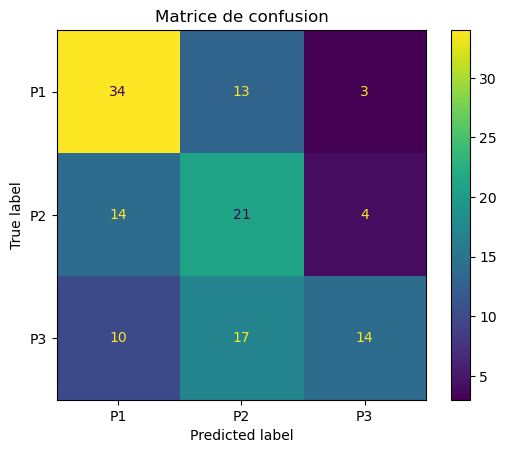

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()
